In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights, VGG16_Weights, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
!mkdir data

In [ ]:
# Baixa e extrai o dataset
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  2177k      0  0:00:05  0:00:05 --:--:-- 2935k
Archive:  data/animais.zip
   creating: data/animais/
   creating: data/animais/val/
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  

In [ ]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
model = models.resnet18(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.layer1[1].conv2.weight

Parameter containing:
tensor([[[[-2.1574e-02, -4.5688e-03,  4.5483e-03],
          [-8.1870e-03,  4.1740e-02,  2.3010e-02],
          [-8.9283e-03,  5.7352e-02,  2.9818e-02]],

         [[ 5.8627e-02,  4.2864e-02,  4.4912e-02],
          [ 2.2281e-02, -1.2969e-02,  7.6099e-03],
          [ 4.5373e-02,  3.0712e-02,  3.7700e-02]],

         [[-1.5456e-02, -3.8692e-02, -4.6010e-02],
          [-2.3123e-02,  2.8293e-02,  4.7790e-03],
          [-2.0328e-02,  1.3756e-02,  2.5883e-02]],

         ...,

         [[ 5.1302e-02,  4.2291e-02,  5.7833e-02],
          [ 4.5210e-02,  5.5850e-02,  1.4318e-02],
          [ 1.4241e-02,  1.7968e-02,  1.4344e-02]],

         [[ 4.6012e-03,  1.2566e-02,  4.8931e-02],
          [-6.5754e-03, -2.6431e-02,  1.5855e-02],
          [ 1.3192e-02,  1.9011e-02,  1.3842e-02]],

         [[ 6.1983e-02,  6.9919e-02,  6.1035e-02],
          [ 6.1253e-02,  9.9557e-02,  5.9060e-02],
          [ 5.8298e-02,  8.1652e-02,  8.1499e-02]]],


        [[[-1.0088e-02, -1.2959

In [ ]:
model.fc.weight

Parameter containing:
tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
        [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
        [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
        ...,
        [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
        [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
        [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]])

In [ ]:
for param in model.parameters():
    print(param.shape)


torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2) # mudando de 1000 classes para 2 classes
model = model.to(device)

In [ ]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch 1, Train Loss: 0.583, Train Accuracy: 73.25%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.413, Val Accuracy: 83.61%


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


Epoch 2, Train Loss: 0.390, Train Accuracy: 86.50%
Epoch 2, Val Loss: 0.246, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Epoch 3, Train Loss: 0.290, Train Accuracy: 91.00%
Epoch 3, Val Loss: 0.184, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:01<00:00,  6.82it/s]


Epoch 4, Train Loss: 0.302, Train Accuracy: 85.25%
Epoch 4, Val Loss: 0.212, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:01<00:00,  7.70it/s]


Epoch 5, Train Loss: 0.290, Train Accuracy: 86.75%
Epoch 5, Val Loss: 0.141, Val Accuracy: 95.08%
Treinamento concluído


In [ ]:
model.layer1[1].conv2.weight

Parameter containing:
tensor([[[[-2.1574e-02, -4.5688e-03,  4.5483e-03],
          [-8.1870e-03,  4.1740e-02,  2.3010e-02],
          [-8.9283e-03,  5.7352e-02,  2.9818e-02]],

         [[ 5.8627e-02,  4.2864e-02,  4.4912e-02],
          [ 2.2281e-02, -1.2969e-02,  7.6099e-03],
          [ 4.5373e-02,  3.0712e-02,  3.7700e-02]],

         [[-1.5456e-02, -3.8692e-02, -4.6010e-02],
          [-2.3123e-02,  2.8293e-02,  4.7790e-03],
          [-2.0328e-02,  1.3756e-02,  2.5883e-02]],

         ...,

         [[ 5.1302e-02,  4.2291e-02,  5.7833e-02],
          [ 4.5210e-02,  5.5850e-02,  1.4318e-02],
          [ 1.4241e-02,  1.7968e-02,  1.4344e-02]],

         [[ 4.6012e-03,  1.2566e-02,  4.8931e-02],
          [-6.5754e-03, -2.6431e-02,  1.5855e-02],
          [ 1.3192e-02,  1.9011e-02,  1.3842e-02]],

         [[ 6.1983e-02,  6.9919e-02,  6.1035e-02],
          [ 6.1253e-02,  9.9557e-02,  5.9060e-02],
          [ 5.8298e-02,  8.1652e-02,  8.1499e-02]]],


        [[[-1.0088e-02, -1.2959

In [ ]:
model.fc.weight

Parameter containing:
tensor([[ 0.0041, -0.0043,  0.0243,  ..., -0.0255, -0.0186, -0.0008],
        [ 0.0302, -0.0199,  0.0203,  ...,  0.0020, -0.0205, -0.0339]],
       device='cuda:0', requires_grad=True)

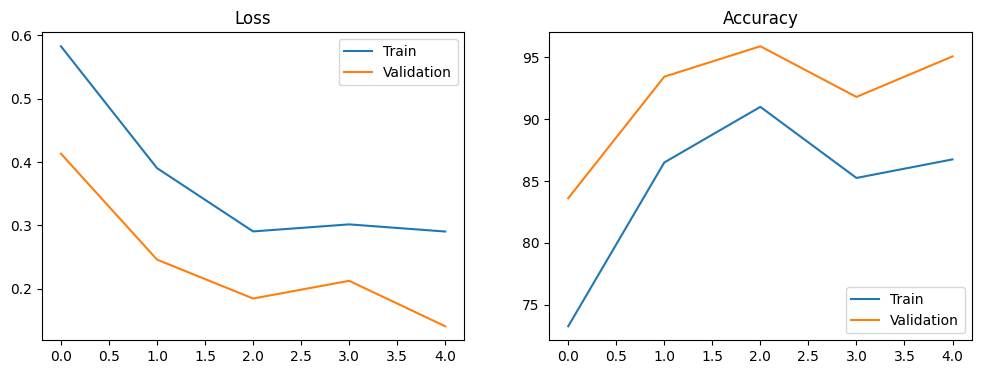

In [ ]:
plot_history(history)

In [ ]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 95.08%


In [ ]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

Output hidden; open in https://colab.research.google.com to view.

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

In [ ]:
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

model = models.resnet18(weights="IMAGENET1K_V1")

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:01<00:00,  7.64it/s]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Train Loss: 0.600, Train Accuracy: 65.00%
Epoch 1, Val Loss: 0.439, Val Accuracy: 77.87%


100%|██████████| 13/13 [00:01<00:00,  6.66it/s]


Epoch 2, Train Loss: 0.380, Train Accuracy: 83.50%
Epoch 2, Val Loss: 0.240, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:01<00:00,  8.37it/s]


Epoch 3, Train Loss: 0.239, Train Accuracy: 91.50%
Epoch 3, Val Loss: 0.209, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:01<00:00,  8.39it/s]


Epoch 4, Train Loss: 0.203, Train Accuracy: 93.25%
Epoch 4, Val Loss: 0.166, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


Epoch 5, Train Loss: 0.171, Train Accuracy: 95.00%
Epoch 5, Val Loss: 0.161, Val Accuracy: 94.26%
Treinamento concluído


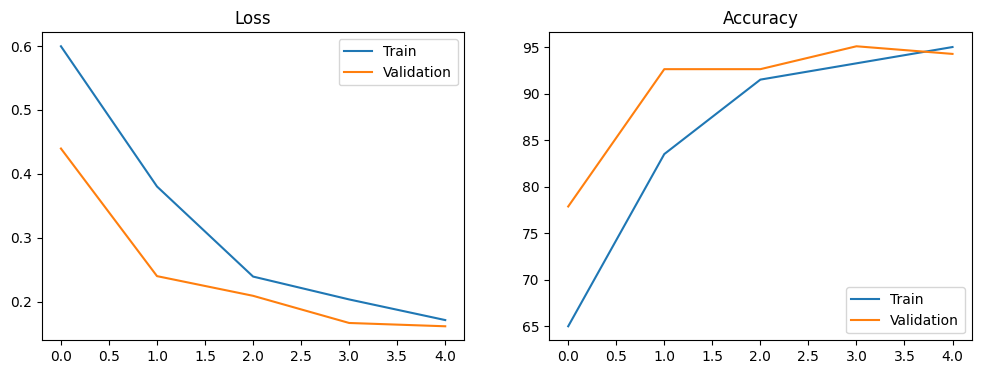

In [ ]:
plot_history(history)

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [ ]:
model = models.resnet18(weights="IMAGENET1K_V1")

In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Descogelar camada layer4
for param in model.layer4[1].parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
      print(name)

layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias


In [ ]:
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2) # mudando de 1000 classes para 2 classes
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [ ]:
# Treinando CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:01<00:00,  7.49it/s]


Epoch 1, Train Loss: 0.616, Train Accuracy: 63.25%
Epoch 1, Val Loss: 0.324, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


Epoch 2, Train Loss: 0.358, Train Accuracy: 87.25%
Epoch 2, Val Loss: 0.204, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Epoch 3, Train Loss: 0.280, Train Accuracy: 88.50%
Epoch 3, Val Loss: 0.149, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


Epoch 4, Train Loss: 0.216, Train Accuracy: 93.25%
Epoch 4, Val Loss: 0.134, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Epoch 5, Train Loss: 0.223, Train Accuracy: 91.50%
Epoch 5, Val Loss: 0.135, Val Accuracy: 95.90%
Treinamento concluído


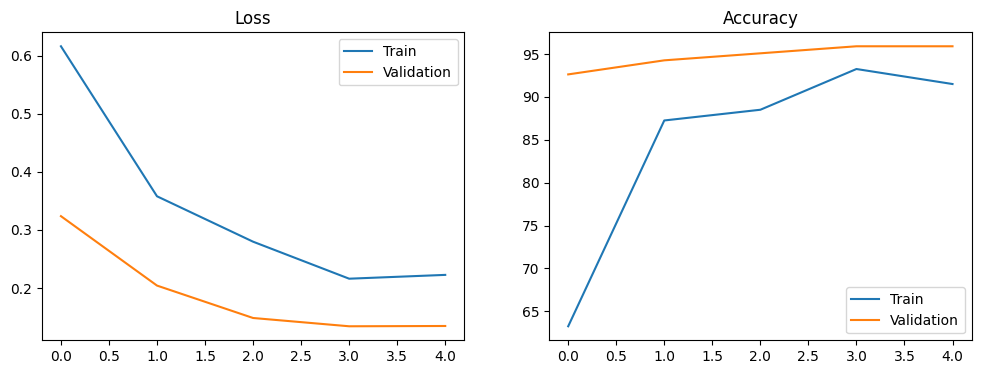

In [ ]:
plot_history(history)

In [ ]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 95.90%


### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [ ]:
model = models.mobilenet_v3_small(weights="IMAGENET1K_V1")

for param in model.parameters():
    param.requires_grad = False

model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 59.7MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:01<00:00,  7.32it/s]


Epoch 1, Train Loss: 0.681, Train Accuracy: 56.50%
Epoch 1, Val Loss: 0.520, Val Accuracy: 86.07%


100%|██████████| 13/13 [00:01<00:00, 11.46it/s]


Epoch 2, Train Loss: 0.535, Train Accuracy: 76.25%
Epoch 2, Val Loss: 0.323, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:01<00:00,  9.96it/s]


Epoch 3, Train Loss: 0.431, Train Accuracy: 85.75%
Epoch 3, Val Loss: 0.231, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:01<00:00, 11.50it/s]


Epoch 4, Train Loss: 0.366, Train Accuracy: 87.50%
Epoch 4, Val Loss: 0.187, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


Epoch 5, Train Loss: 0.333, Train Accuracy: 87.75%
Epoch 5, Val Loss: 0.169, Val Accuracy: 94.26%
Treinamento concluído


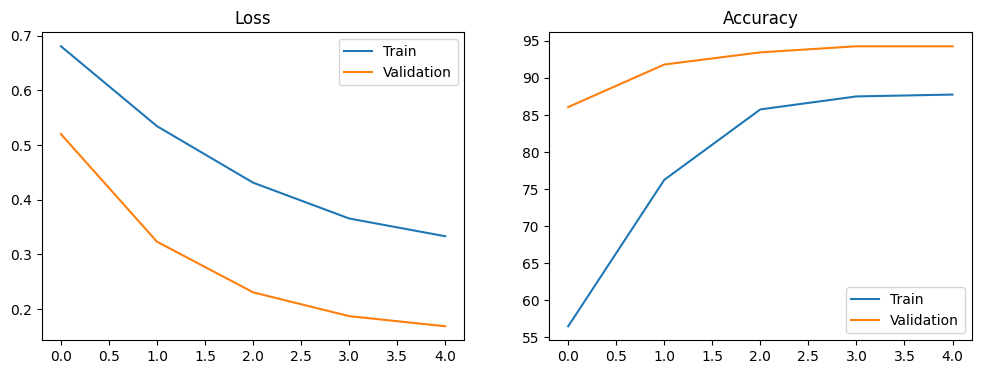

In [ ]:
plot_history(history)

In [ ]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 94.26%
